In [25]:
import ee_s1_ard
import ee 
ee.Authenticate()
ee.Initialize(project='ee-caiosimplicioarantes') 


In [26]:
from ee_s1_ard import S1ARDImageCollection

In [27]:
import zipfile
import geopandas as gpd
import logging
import os
import locale
import requests

#from ravi_ee_tools import load_aoi_from_shapefile # Assuming your_module_name.py contains the function
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
app_logger = logging.getLogger(__name__)
logger = logging.getLogger(__name__)

In [28]:

def load_aoi_from_shapefile(shapefile_path):
    """
    Loads an Area of Interest (AOI) from a shapefile (or a zip containing a shapefile)
    and converts it into an Earth Engine FeatureCollection.

    Args:
        shapefile_path (str): The path to the shapefile (.shp) or a zip archive
                              containing a .shp file.

    Returns:
        ee.FeatureCollection: An Earth Engine FeatureCollection representing the AOI.

    Raises:
        FileNotFoundError: If no .shp file is found inside a zip archive.
        ValueError: If the shapefile does not contain any geometries.
        Exception: For other errors during shapefile reading or processing.
    """
    gpd_aoi = None # Use a distinct name for the geopandas DataFrame

    if shapefile_path.endswith(".zip"):
        with zipfile.ZipFile(shapefile_path, "r") as zip_ref:
            shapefile_within_zip = None
            for file in zip_ref.namelist():
                if file.lower().endswith(".shp"): # Use .lower() for case-insensitivity
                    shapefile_within_zip = file
                    break
            if not shapefile_within_zip:
                logger.error(f"No .shp file found inside the zip archive: {shapefile_path}")
                raise FileNotFoundError(
                    f"No .shp file found inside the zip archive: {shapefile_path}"
                )

            # Read shapefile directly from the zip archive.
            gpd_aoi = gpd.read_file(f"zip://{shapefile_path}/{shapefile_within_zip}")
    else:
        gpd_aoi = gpd.read_file(shapefile_path)

    # Reproject the GeoDataFrame to EPSG:4326 to ensure correct
    # coordinates for Earth Engine.
    gpd_aoi = gpd_aoi.to_crs(epsg=4326)

    if gpd_aoi.empty:
        logger.error(f"The shapefile at {shapefile_path} does not contain any geometries.")
        raise ValueError(f"The shapefile at {shapefile_path} does not contain any geometries.")

    # Dissolve multiple features into a single geometry if necessary.
    if len(gpd_aoi) > 1:
        logger.info("Multiple features found; dissolving into a single geometry.")
        gpd_aoi = gpd_aoi.dissolve()

    # Extract the first geometry.
    # It's safer to ensure there's at least one geometry before iloc[0]
    if gpd_aoi.empty: # Re-check after dissolve if it became empty (unlikely but robust)
         logger.error(f"The shapefile at {shapefile_path} became empty after dissolve.")
         raise ValueError(f"The shapefile at {shapefile_path} became empty after dissolve.")

    geometry = gpd_aoi.geometry.iloc[0]

    # Convert the geometry to GeoJSON format.
    geojson = geometry.__geo_interface__

    # Remove any third dimension from the coordinates.
    # Note: GeoJSON can support 3D, but Earth Engine often expects 2D.
    # This part of the logic is robust.
    if geojson["type"] == "Polygon":
        geojson["coordinates"] = [
            list(map(lambda coord: coord[:2], ring)) for ring in geojson["coordinates"]
        ]
    elif geojson["type"] == "MultiPolygon":
        geojson["coordinates"] = [
            [list(map(lambda coord: coord[:2], ring)) for ring in polygon]
            for polygon in geojson["coordinates"]
        ]

    # Create an Earth Engine geometry object.
    ee_geometry = ee.Geometry(geojson)
    feature = ee.Feature(ee_geometry)
    ee_feature_collection = ee.FeatureCollection([feature])

    logger.info("AOI defined successfully.")
    return ee_feature_collection

In [29]:
geometry = load_aoi_from_shapefile('contorno_area_total.zip')


2025-08-08 18:37:34,091 - __main__ - INFO - AOI defined successfully.


In [30]:

start_date = '2021-01-01'
stop_date = '2021-12-31'


In [31]:

processor = S1ARDImageCollection(
    geometry=geometry,
    start_date=start_date,
    stop_date=stop_date,
    polarization="VVVH",
    apply_border_noise_correction=True,
    apply_terrain_flattening=True,
    apply_speckle_filtering=True,
    output_format="DB",
    ascending=False # False for descending orbit, True for ascending orbit
)

collection = processor.get_collection()

collection.size().getInfo()  # This will trigger the processing and return the size of the collection

28

In [32]:
def add_vvvh_ratio_band(image):
    ratio = image.select("VV").divide(image.select("VH")).rename("VVVH_ratio")
    return image.addBands(ratio)

collection = collection.map(add_vvvh_ratio_band)

In [33]:
import pandas as pd

# Extract the VVVH_ratio band and reduce over the geometry to get mean values for each image
def get_vvvh_ratio_mean(image):
    stats = image.select("VVVH_ratio").reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geometry,
        scale=10,
        maxPixels=1e9
    )
    # Get image date
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {
        'date': date,
        'VVVH_ratio_mean': stats.get('VVVH_ratio')
    })

# Map over the collection to get time series
vvvh_ratio_ts = collection.map(get_vvvh_ratio_mean).getInfo()

# Convert to pandas DataFrame for easier handling

data = [
    {'date': f['properties']['date'], 'VVVH_ratio_mean': f['properties']['VVVH_ratio_mean']}
    for f in vvvh_ratio_ts['features']
]
df_vvvh_ratio = pd.DataFrame(data)
print(df_vvvh_ratio)

          date  VVVH_ratio_mean
0   2021-01-10         0.503852
1   2021-01-22         0.511062
2   2021-02-03         0.470003
3   2021-02-15         0.457711
4   2021-02-27         0.541113
5   2021-03-11         0.604315
6   2021-03-23         0.573493
7   2021-04-04         0.571548
8   2021-04-16         0.568343
9   2021-04-28         0.569271
10  2021-05-10         0.566019
11  2021-05-22         0.600823
12  2021-06-03         0.578715
13  2021-06-15         0.569901
14  2021-06-27         0.586956
15  2021-07-09         0.597299
16  2021-07-21         0.644485
17  2021-08-02         0.622673
18  2021-08-14         0.638636
19  2021-08-26         0.633520
20  2021-09-07         0.633209
21  2021-09-19         0.636488
22  2021-10-01         0.638322
23  2021-10-13         0.628774
24  2021-10-25         0.557453
25  2021-11-18         0.659072
26  2021-12-12         0.545942
27  2021-12-24         0.527466


2025-08-08 18:37:46,181 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-08-08 18:37:46,184 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


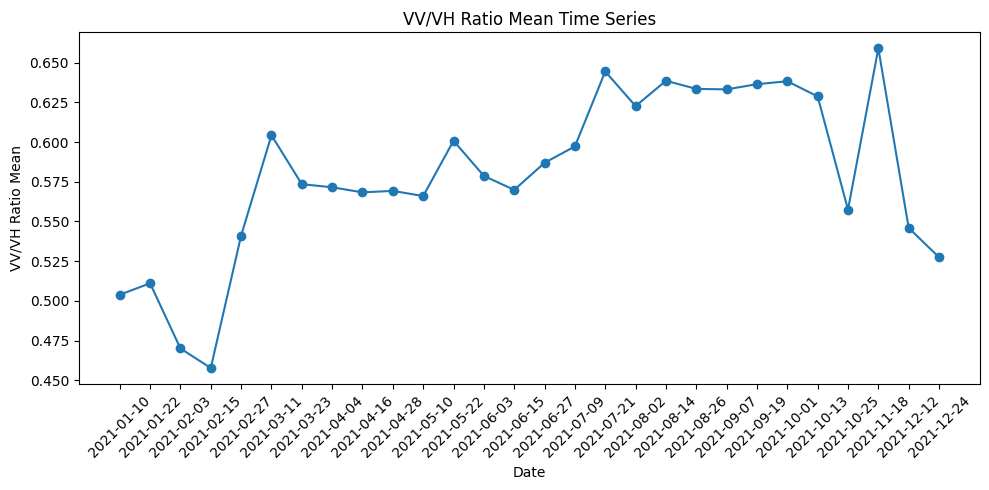

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_vvvh_ratio['date'], df_vvvh_ratio['VVVH_ratio_mean'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('VV/VH Ratio Mean')
plt.title('VV/VH Ratio Mean Time Series')
plt.tight_layout()
plt.show()